## holiday days

In [141]:
import pandas as pd
from datetime import datetime, timedelta


### read data

In [142]:
df_bsr_data = pd.read_csv('../data/trash-amounts.csv', sep=';', dtype=str)
df_holidays = pd.read_csv('../data/holidays.csv', sep=',', quotechar='"')

### clean date column and convert to datetime

In [143]:
df_bsr_data['Datum'] = pd.to_datetime(df_bsr_data['Datum'], format='%d.%m.%y', errors='coerce')

print(df_bsr_data['Datum'].dtype)

datetime64[ns]


### parse holiday periods into a list of dates

In [144]:
def parse_holiday_period(holiday_str, year):
    """
    Wandelt einen Ferien-Zeitraum-String (z.B. "14.04. - 25.04. / 02.05. / 30.05.")
    in eine Liste von (start_date, end_date)-Tupeln um.
    """
    # Vereinheitliche die Trennzeichen
    holiday_str = holiday_str.replace('/', '+')
    parts = holiday_str.split('+')
    intervals = []
    
    for part in parts:
        part = part.strip()
        if not part:
            continue
        if '-' in part:
            start_str, end_str = part.split('-')
            # Entferne überflüssige Punkte und Leerzeichen
            start_str = start_str.strip().rstrip('.')
            end_str = end_str.strip().rstrip('.')
            # Erzeuge Start- und Enddatum
            start_date = datetime.strptime(f"{start_str}.{year}", "%d.%m.%Y")
            end_date = datetime.strptime(f"{end_str}.{year}", "%d.%m.%Y")
            # Falls das Enddatum vor dem Startdatum liegt (z.B. 23.12. - 04.01.), 
            # dann ordne das Enddatum dem Folgejahr zu.
            if start_date > end_date:
                end_date = datetime.strptime(f"{end_str}.{year+1}", "%d.%m.%Y")
            intervals.append((start_date, end_date))
        else:
            # Einzeltermin – hier ebenfalls überflüssige Punkte entfernen
            date_str = part.strip().rstrip('.')
            date_obj = datetime.strptime(f"{date_str}.{year}", "%d.%m.%Y")
            intervals.append((date_obj, date_obj))
    return intervals

### collect all dates into a dictionary

In [145]:
holidays = {}

for idx, row in df_holidays.iterrows():
    bundesland = row['Bundesland']
    year = int(row['Jahr'])
    if bundesland not in holidays:
        holidays[bundesland] = {}
    if year not in holidays[bundesland]:
        holidays[bundesland][year] = set()
        
    # Alle Ferien-Spalten (ab der 3. Spalte) durchgehen
    for col in df_holidays.columns[2:]:
        # Prüfen, ob in der Spalte ein Wert steht
        if pd.isna(row[col]):
            continue
        holiday_str = row[col]
        intervals = parse_holiday_period(holiday_str, year)
        for start_date, end_date in intervals:
            # Füge alle Tage im Intervall (inklusive Start und Ende) hinzu
            delta_days = (end_date - start_date).days
            for i in range(delta_days + 1):
                tag = start_date + timedelta(days=i)
                holidays[bundesland][year].add(tag)

### create a new dataframe with all dates

In [146]:
result_rows = []
for bundesland, years in holidays.items():
    for year, holiday_set in years.items():
        start_year = datetime(year, 1, 1)
        end_year = datetime(year, 12, 31)
        for tag in pd.date_range(start_year, end_year):
            tag_dt = tag.to_pydatetime()
            result_rows.append({
                'Bundesland': bundesland,
                'Datum': tag,
                'is_holiday': tag_dt in holiday_set
            })

result_df = pd.DataFrame(result_rows)
print(result_df.head(20))

   Bundesland      Datum  is_holiday
0      Berlin 2019-01-01       False
1      Berlin 2019-01-02       False
2      Berlin 2019-01-03       False
3      Berlin 2019-01-04       False
4      Berlin 2019-01-05       False
5      Berlin 2019-01-06       False
6      Berlin 2019-01-07       False
7      Berlin 2019-01-08       False
8      Berlin 2019-01-09       False
9      Berlin 2019-01-10       False
10     Berlin 2019-01-11       False
11     Berlin 2019-01-12       False
12     Berlin 2019-01-13       False
13     Berlin 2019-01-14       False
14     Berlin 2019-01-15       False
15     Berlin 2019-01-16       False
16     Berlin 2019-01-17       False
17     Berlin 2019-01-18       False
18     Berlin 2019-01-19       False
19     Berlin 2019-01-20       False


In [147]:
# Extract holiday dates from df_holidays
holiday_dates = {}
for holiday_type in holiday_types:
    holiday_dates[holiday_type] = set()
    for idx, row in df_holidays.iterrows():
        year = row['Jahr']
        intervals = parse_holiday_period(row[holiday_type], year)
        for start_date, end_date in intervals:
            delta_days = (end_date - start_date).days
            for i in range(delta_days + 1):
                tag = start_date + timedelta(days=i)
                holiday_dates[holiday_type].add(tag)

result_rows = []
holiday_types = ['Winterferien', 'Osterferien', 'Pfingstferien', 'Sommerferien', 'Herbstferien', 'Weihnachtsferien']

for bundesland, years in holidays.items():
    for year, holiday_set in years.items():
        start_year = datetime(year, 1, 1)
        end_year = datetime(year, 12, 31)
        for tag in pd.date_range(start_year, end_year):
            tag_dt = tag.to_pydatetime()
            row = {
                'Bundesland': bundesland,
                'Datum': tag,
                'is_holiday': tag_dt in holiday_set
            }
            for holiday_type in holiday_types:
                row[holiday_type] = tag_dt in holiday_dates[holiday_type]
            result_rows.append(row)

result_df = pd.DataFrame(result_rows)
print(result_df.head(20))

   Bundesland      Datum  is_holiday  Winterferien  Osterferien  \
0      Berlin 2019-01-01       False         False        False   
1      Berlin 2019-01-02       False         False        False   
2      Berlin 2019-01-03       False         False        False   
3      Berlin 2019-01-04       False         False        False   
4      Berlin 2019-01-05       False         False        False   
5      Berlin 2019-01-06       False         False        False   
6      Berlin 2019-01-07       False         False        False   
7      Berlin 2019-01-08       False         False        False   
8      Berlin 2019-01-09       False         False        False   
9      Berlin 2019-01-10       False         False        False   
10     Berlin 2019-01-11       False         False        False   
11     Berlin 2019-01-12       False         False        False   
12     Berlin 2019-01-13       False         False        False   
13     Berlin 2019-01-14       False         False        Fals

In [148]:
# Ersetze True und False durch 1 und 0 in result_df
result_df.replace({True: 1, False: 0}, inplace=True)

print(result_df.head())

  Bundesland      Datum  is_holiday  Winterferien  Osterferien  Pfingstferien  \
0     Berlin 2019-01-01           0             0            0              0   
1     Berlin 2019-01-02           0             0            0              0   
2     Berlin 2019-01-03           0             0            0              0   
3     Berlin 2019-01-04           0             0            0              0   
4     Berlin 2019-01-05           0             0            0              0   

   Sommerferien  Herbstferien  Weihnachtsferien  
0             0             0                 0  
1             0             0                 0  
2             0             0                 0  
3             0             0                 0  
4             0             0                 0  


/var/folders/2p/ddd52pfd5nlbgqlwqtdhlv480000gn/T/ipykernel_38858/71595205.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result_df.replace({True: 1, False: 0}, inplace=True)


In [149]:
# Erstelle Dummy-Variablen für jeden Wochentag
weekday_dummies = pd.get_dummies(result_df['Datum'].dt.day_name(), prefix='weekday')

# Füge die Dummy-Variablen zum DataFrame hinzu, ohne vorherige Spalten zu verlieren
result_df = pd.concat([result_df, weekday_dummies], axis=1)

result_df.replace({True: 1, False: 0}, inplace=True)

print(result_df.head())

  Bundesland      Datum  is_holiday  Winterferien  Osterferien  Pfingstferien  \
0     Berlin 2019-01-01           0             0            0              0   
1     Berlin 2019-01-02           0             0            0              0   
2     Berlin 2019-01-03           0             0            0              0   
3     Berlin 2019-01-04           0             0            0              0   
4     Berlin 2019-01-05           0             0            0              0   

   Sommerferien  Herbstferien  Weihnachtsferien  weekday_Friday  \
0             0             0                 0               0   
1             0             0                 0               0   
2             0             0                 0               0   
3             0             0                 0               1   
4             0             0                 0               0   

   weekday_Monday  weekday_Saturday  weekday_Sunday  weekday_Thursday  \
0               0                 0  

/var/folders/2p/ddd52pfd5nlbgqlwqtdhlv480000gn/T/ipykernel_38858/2288319138.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result_df.replace({True: 1, False: 0}, inplace=True)


In [150]:
num_lags = 3  # Anzahl der Lag-Spalten, die hinzugefügt werden sollen
features = ['is_holiday', 
            'Winterferien', 
            'Osterferien', 
            'Pfingstferien', 
            'Sommerferien', 
            'Herbstferien', 
            'Weihnachtsferien', 
            'weekday_Monday', 
            'weekday_Tuesday',
            'weekday_Wednesday',
            'weekday_Thursday',
            'weekday_Friday',
            'weekday_Saturday',
            'weekday_Sunday'
            ]

for feature in features:
    for lag in range(1, num_lags + 1):
        result_df[f'{feature}_lag_{lag}'] = result_df[feature].shift(lag)

print(result_df.head())

result_df.to_csv('../data/holidays-and-weekdays.csv', index=False)

  Bundesland      Datum  is_holiday  Winterferien  Osterferien  Pfingstferien  \
0     Berlin 2019-01-01           0             0            0              0   
1     Berlin 2019-01-02           0             0            0              0   
2     Berlin 2019-01-03           0             0            0              0   
3     Berlin 2019-01-04           0             0            0              0   
4     Berlin 2019-01-05           0             0            0              0   

   Sommerferien  Herbstferien  Weihnachtsferien  weekday_Friday  ...  \
0             0             0                 0               0  ...   
1             0             0                 0               0  ...   
2             0             0                 0               0  ...   
3             0             0                 0               1  ...   
4             0             0                 0               0  ...   

   weekday_Thursday_lag_3  weekday_Friday_lag_1  weekday_Friday_lag_2  \
0      

In [151]:
# Merge df_bsr_data with result_df on the 'Datum' column
df_bsr_data = df_bsr_data.merge(result_df[['Datum', 
                                           'is_holiday',
                                           'Winterferien',
                                           'Winterferien_lag_1',
                                           'Winterferien_lag_2',
                                             'Winterferien_lag_3',
                                           'Osterferien',
                                           'Osterferien_lag_1',
                                             'Osterferien_lag_2',
                                                'Osterferien_lag_3',
                                           'Pfingstferien',
                                            'Pfingstferien_lag_1',
                                            'Pfingstferien_lag_2',
                                            'Pfingstferien_lag_3',
                                            'Sommerferien',
                                            'Sommerferien_lag_1',
                                            'Sommerferien_lag_2',
                                            'Sommerferien_lag_3',
                                            'Herbstferien',
                                            'Herbstferien_lag_1',
                                            'Herbstferien_lag_2',
                                            'Herbstferien_lag_3',
                                            'Weihnachtsferien',
                                            'Weihnachtsferien_lag_1',
                                            'Weihnachtsferien_lag_2',
                                            'Weihnachtsferien_lag_3',
                                            'weekday_Monday',
                                            'weekday_Monday_lag_1',
                                            'weekday_Monday_lag_2',
                                            'weekday_Monday_lag_3',
                                            'weekday_Tuesday',
                                            'weekday_Tuesday_lag_1',
                                            'weekday_Tuesday_lag_2',
                                            'weekday_Tuesday_lag_3',
                                            'weekday_Wednesday',
                                            'weekday_Wednesday_lag_1',
                                            'weekday_Wednesday_lag_2',
                                            'weekday_Wednesday_lag_3',
                                            'weekday_Thursday',
                                            'weekday_Thursday_lag_1',
                                            'weekday_Thursday_lag_2',
                                            'weekday_Thursday_lag_3',
                                            'weekday_Friday',
                                            'weekday_Friday_lag_1',
                                            'weekday_Friday_lag_2',
                                            'weekday_Friday_lag_3',
                                            'weekday_Saturday',
                                            'weekday_Saturday_lag_1',
                                            'weekday_Saturday_lag_2',
                                            'weekday_Saturday_lag_3',
                                            'weekday_Sunday',
                                            'weekday_Sunday_lag_1',
                                            'weekday_Sunday_lag_2',
                                            'weekday_Sunday_lag_3'
                                           ]], on='Datum', how='left', suffixes=('', '_y'))

# Drop the duplicate 'is_holiday_y' column if it exists
df_bsr_data.drop(columns=['is_holiday_y'], inplace=True, errors='ignore')

print(df_bsr_data.head())

  Monat KW  Jahr      Datum  Hof Schicht Tour Tonnage Abfallart  is_holiday  \
0     1  1  2019 2019-01-02  VMF       1    1    5,59       BIO         0.0   
1     1  1  2019 2019-01-02  VMF       1    4    3,23       BIO         0.0   
2     1  1  2019 2019-01-02  VMF       1    5    5,68       BIO         0.0   
3     1  1  2019 2019-01-02  VMF       1    6    5,48       BIO         0.0   
4     1  1  2019 2019-01-02  VMF       1    7    7,84       BIO         0.0   

   ...  Sommerferien  Herbstferien  Weihnachtsferien  weekday_Monday  \
0  ...           0.0           0.0               0.0             0.0   
1  ...           0.0           0.0               0.0             0.0   
2  ...           0.0           0.0               0.0             0.0   
3  ...           0.0           0.0               0.0             0.0   
4  ...           0.0           0.0               0.0             0.0   

   weekday_Tuesday  weekday_Wednesday  weekday_Thursday  weekday_Friday  \
0              0.

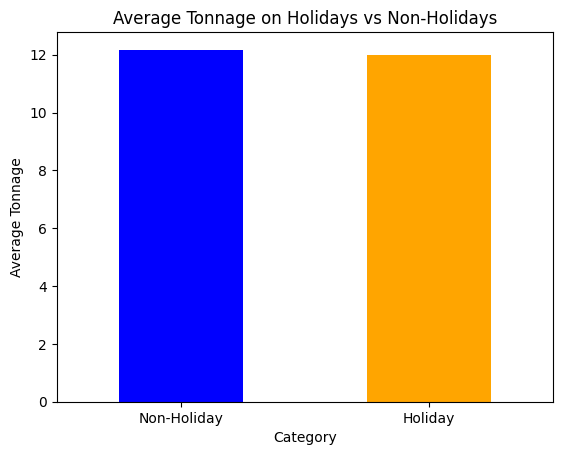

In [152]:
import matplotlib.pyplot as plt

# Konvertiere die Tonnage-Spalte in numerische Werte
df_bsr_data['Tonnage'] = pd.to_numeric(df_bsr_data['Tonnage'].str.replace(',', '.'), errors='coerce')

# Gruppiere die Daten nach Feiertagen und berechne die durchschnittliche Müllmenge
average_tonnage = df_bsr_data.groupby('is_holiday')['Tonnage'].mean()

# Plotten der Ergebnisse
average_tonnage.plot(kind='bar', color=['blue', 'orange'])
plt.xlabel('Category')
plt.ylabel('Average Tonnage')
plt.title('Average Tonnage on Holidays vs Non-Holidays')
plt.xticks(ticks=[0, 1], labels=['Non-Holiday', 'Holiday'], rotation=0)
plt.show()

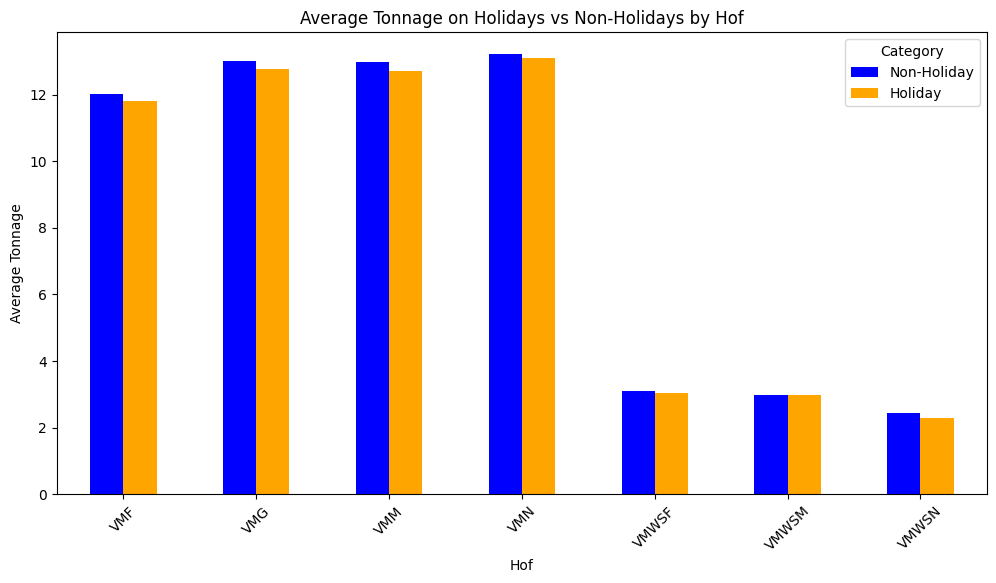

In [153]:
# Gruppiere die Daten nach Hof und Feiertagen und berechne die durchschnittliche Müllmenge
average_tonnage_by_hof = df_bsr_data.groupby(['Hof', 'is_holiday'])['Tonnage'].mean().unstack()

# Plotten der Ergebnisse
average_tonnage_by_hof.plot(kind='bar', figsize=(12, 6), color=['blue', 'orange'])
plt.xlabel('Hof')
plt.ylabel('Average Tonnage')
plt.title('Average Tonnage on Holidays vs Non-Holidays by Hof')
plt.xticks(rotation=45)
plt.legend(title='Category', labels=['Non-Holiday', 'Holiday'])
plt.show()

## Zusammenhang zwischen Müllmengen und Wochenenden

In [154]:
# Füge eine neue Spalte 'is_weekend' hinzu, die überprüft, ob das Datum ein Wochenende ist
df_bsr_data['is_weekend'] = df_bsr_data['Datum'].dt.weekday >= 5

print(df_bsr_data[['Datum', 'is_weekend']].head())

       Datum  is_weekend
0 2019-01-02       False
1 2019-01-02       False
2 2019-01-02       False
3 2019-01-02       False
4 2019-01-02       False


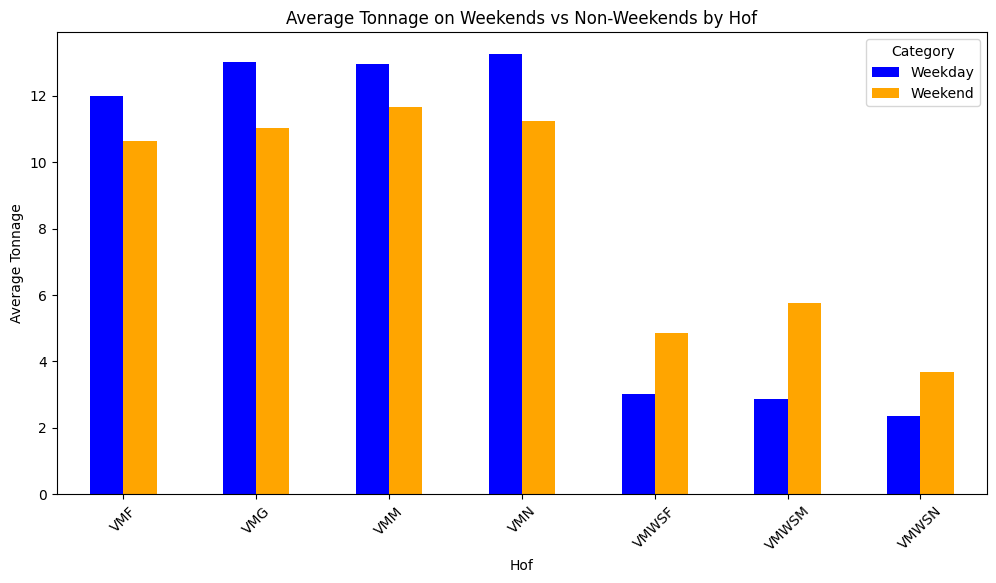

In [155]:
# Gruppiere die Daten nach Hof und Feiertagen und berechne die durchschnittliche Müllmenge
average_tonnage_by_hof = df_bsr_data.groupby(['Hof', 'is_weekend'])['Tonnage'].mean().unstack()

# Plotten der Ergebnisse
average_tonnage_by_hof.plot(kind='bar', figsize=(12, 6), color=['blue', 'orange'])
plt.xlabel('Hof')
plt.ylabel('Average Tonnage')
plt.title('Average Tonnage on Weekends vs Non-Weekends by Hof')
plt.xticks(rotation=45)
plt.legend(title='Category', labels=['Weekday', 'Weekend'])
plt.show()

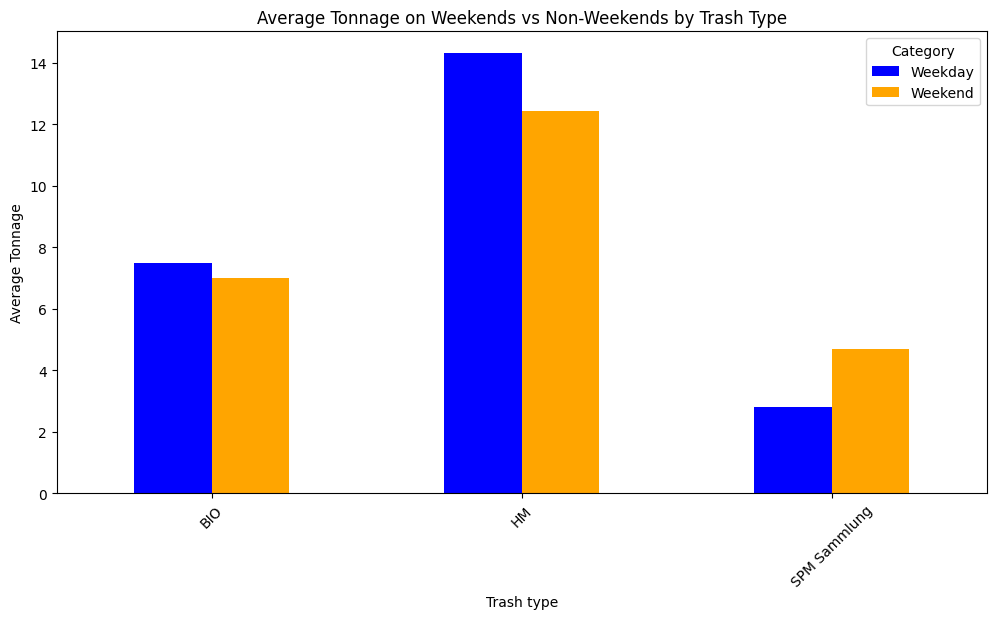

In [156]:
# Gruppiere die Daten nach Hof und Feiertagen und berechne die durchschnittliche Müllmenge
average_tonnage_by_hof = df_bsr_data.groupby(['Abfallart', 'is_weekend'])['Tonnage'].mean().unstack()

# Plotten der Ergebnisse
average_tonnage_by_hof.plot(kind='bar', figsize=(12, 6), color=['blue', 'orange'])
plt.xlabel('Trash type')
plt.ylabel('Average Tonnage')
plt.title('Average Tonnage on Weekends vs Non-Weekends by Trash Type')
plt.xticks(rotation=45)
plt.legend(title='Category', labels=['Weekday', 'Weekend'])
plt.show()

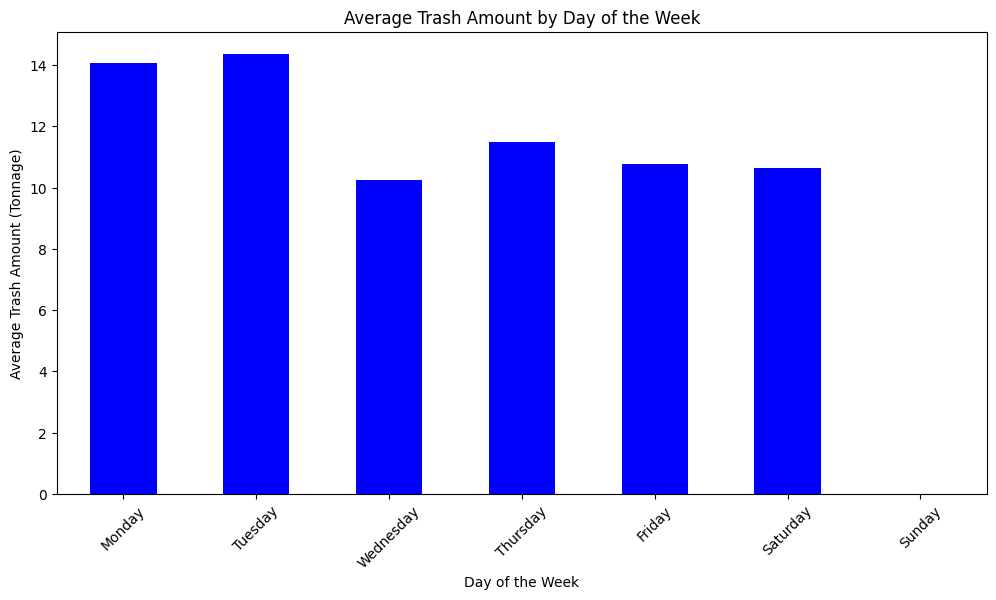

In [157]:
# Füge eine neue Spalte 'Wochentag' hinzu, die den Wochentag des Datums enthält
df_bsr_data['Wochentag'] = df_bsr_data['Datum'].dt.day_name()

# Gruppiere die Daten nach Wochentag und berechne die durchschnittliche Müllmenge
average_tonnage_by_weekday = df_bsr_data.groupby('Wochentag')['Tonnage'].mean()

# Sortiere die Wochentage in der richtigen Reihenfolge
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
average_tonnage_by_weekday = average_tonnage_by_weekday.reindex(weekday_order)

# Plotten der Ergebnisse
average_tonnage_by_weekday.plot(kind='bar', figsize=(12, 6), color='blue')
plt.xlabel('Day of the Week')
plt.ylabel('Average Trash Amount (Tonnage)')
plt.title('Average Trash Amount by Day of the Week')
plt.xticks(rotation=45)
plt.show()

In [158]:
print(df_bsr_data.head())


  Monat KW  Jahr      Datum  Hof Schicht Tour  Tonnage Abfallart  is_holiday  \
0     1  1  2019 2019-01-02  VMF       1    1     5.59       BIO         0.0   
1     1  1  2019 2019-01-02  VMF       1    4     3.23       BIO         0.0   
2     1  1  2019 2019-01-02  VMF       1    5     5.68       BIO         0.0   
3     1  1  2019 2019-01-02  VMF       1    6     5.48       BIO         0.0   
4     1  1  2019 2019-01-02  VMF       1    7     7.84       BIO         0.0   

   ...  Weihnachtsferien  weekday_Monday  weekday_Tuesday  weekday_Wednesday  \
0  ...               0.0             0.0              0.0                1.0   
1  ...               0.0             0.0              0.0                1.0   
2  ...               0.0             0.0              0.0                1.0   
3  ...               0.0             0.0              0.0                1.0   
4  ...               0.0             0.0              0.0                1.0   

   weekday_Thursday  weekday_Friday  w

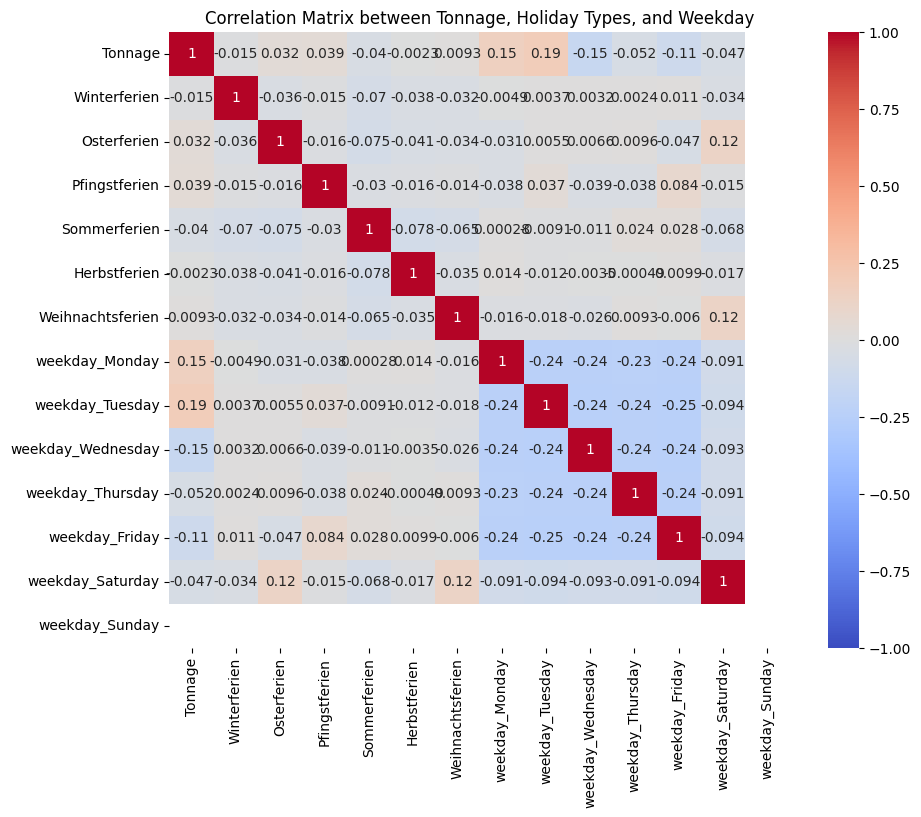

In [161]:
import seaborn as sns

# Aktualisiere die Korrelationsmatrix mit der neuen Spalte
correlation_matrix = df_bsr_data[['Tonnage', 
                                  'Winterferien',
                                           'Winterferien_lag_1',
                                           'Winterferien_lag_2',
                                             'Winterferien_lag_3',
                                           'Osterferien',
                                           'Osterferien_lag_1',
                                             'Osterferien_lag_2',
                                                'Osterferien_lag_3',
                                           'Pfingstferien',
                                            'Pfingstferien_lag_1',
                                            'Pfingstferien_lag_2',
                                            'Pfingstferien_lag_3',
                                            'Sommerferien',
                                            'Sommerferien_lag_1',
                                            'Sommerferien_lag_2',
                                            'Sommerferien_lag_3',
                                            'Herbstferien',
                                            'Herbstferien_lag_1',
                                            'Herbstferien_lag_2',
                                            'Herbstferien_lag_3',
                                            'Weihnachtsferien',
                                            'Weihnachtsferien_lag_1',
                                            'Weihnachtsferien_lag_2',
                                            'Weihnachtsferien_lag_3',
                                            'weekday_Monday',
                                            'weekday_Monday_lag_1',
                                            'weekday_Monday_lag_2',
                                            'weekday_Monday_lag_3',
                                            'weekday_Tuesday',
                                            'weekday_Tuesday_lag_1',
                                            'weekday_Tuesday_lag_2',
                                            'weekday_Tuesday_lag_3',
                                            'weekday_Wednesday',
                                            'weekday_Wednesday_lag_1',
                                            'weekday_Wednesday_lag_2',
                                            'weekday_Wednesday_lag_3',
                                            'weekday_Thursday',
                                            'weekday_Thursday_lag_1',
                                            'weekday_Thursday_lag_2',
                                            'weekday_Thursday_lag_3',
                                            'weekday_Friday',
                                            'weekday_Friday_lag_1',
                                            'weekday_Friday_lag_2',
                                            'weekday_Friday_lag_3',
                                            'weekday_Saturday',
                                            'weekday_Saturday_lag_1',
                                            'weekday_Saturday_lag_2',
                                            'weekday_Saturday_lag_3',
                                            'weekday_Sunday',
                                            'weekday_Sunday_lag_1',
                                            'weekday_Sunday_lag_2',
                                            'weekday_Sunday_lag_3'
                                  ]].corr()

# Plotten der aktualisierten Korrelationsmatrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix between Tonnage, Holiday Types, and Weekday')
plt.show()